In [241]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import joblib

optuna.logging.set_verbosity(optuna.logging.WARNING)
RS = 42

In [194]:
df = pd.read_csv("UCI_Credit_Card.csv")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [51]:
df["default.payment.next.month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

In [195]:
X = df.drop(["ID", "default.payment.next.month"], axis=1)
y = df["default.payment.next.month"]

## Baseline
The `Gini coefficient` will be used as a metric for quality assessment for several reasons:
1) Class imbalance
2) Excellent interpretation for binary classification problems

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RS, 
                                                    test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=RS, test_size=0.2)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_train.columns)

In [66]:
X_train_sc

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.135339,0.811152,0.188240,0.853805,-1.240828,0.900046,-1.568574,-1.543454,-1.531952,-0.658623,...,-0.674995,-0.671642,-0.658037,-0.547990,-0.332271,-0.238452,-0.289872,-0.287805,0.089790,-0.181550
1,0.405410,-1.232815,0.188240,0.853805,-0.590113,0.010094,0.104737,0.133538,0.181543,0.222478,...,2.025730,1.458527,1.084230,0.966582,0.113205,0.044577,-0.006871,-0.048160,-0.025218,-0.225959
2,-0.210890,0.811152,0.188240,-1.062864,-0.590113,-1.769810,-1.568574,-1.543454,-1.531952,-1.539725,...,-0.674995,-0.671642,-0.661669,-0.635649,-0.332271,-0.238452,-0.289872,-0.301688,-0.235787,-0.296154
3,0.713559,0.811152,-1.070578,0.853805,-0.373208,0.010094,0.104737,0.133538,0.181543,-0.658623,...,-0.489461,-0.671642,-0.652507,-0.654479,-0.216065,-0.121514,-0.289872,-0.266667,-0.305727,-0.296154
4,-0.904227,-1.232815,0.188240,0.853805,-1.349281,0.010094,0.104737,0.133538,0.181543,0.222478,...,0.054567,0.101856,-0.509547,-0.522278,-0.216065,-0.144434,-0.006433,0.042269,-0.274559,-0.267503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,0.559485,-1.232815,0.188240,0.853805,-1.023923,0.010094,0.104737,0.133538,0.181543,0.222478,...,1.752337,2.006699,2.236007,2.499951,0.074450,0.014913,0.048580,0.113562,0.566966,-0.296154
21596,1.715046,0.811152,0.188240,0.853805,-0.807018,-0.879858,-0.731918,-0.704958,-0.675204,-0.658623,...,-0.644661,-0.637337,-0.641954,-0.598373,-0.257085,-0.155309,-0.167804,-0.226080,-0.095969,-0.172897
21597,-0.750152,0.811152,0.188240,-1.062864,0.928224,0.010094,0.104737,0.133538,0.181543,0.222478,...,0.343349,0.421548,0.169340,0.194837,-0.184399,-0.124711,0.056572,-0.176863,-0.182490,-0.182983
21598,-0.133852,0.811152,-1.070578,-1.062864,0.711319,-0.879858,1.778047,1.810531,-0.675204,0.222478,...,-0.661564,-0.656724,-0.645881,-0.642295,-0.277654,-0.238452,-0.237049,-0.301688,-0.260471,-0.296154


In [91]:
def fit_and_metrics(model):
    cv_scores = cross_val_score(model, X=X_train_sc, 
                y=y_train, scoring="roc_auc", cv=5)
    print(f"Train Gini: {round(np.mean(cv_scores*2-1), 2)}")
    
    model.fit(X_train_sc, y_train)
    model_prediction = model.predict_proba(X_val_sc)[:, 1]
    model_roc = roc_auc_score(y_val, model_prediction)
    
    print(f"Val Gini: {round(model_roc*2-1, 2)}")
    return model

In [87]:
log_base = LogisticRegression(max_iter=10000, random_state=RS)
fit_and_metrics(log_base)

Train Gini: 0.45
Val Gini: 0.41


LogisticRegression(max_iter=10000, random_state=42)

## Improving the predictive power of logistic regression
### Feature selection via Lasso

In [92]:
log_lasso_filter = LogisticRegression(max_iter=10000, random_state=RS, 
                                      penalty="l1", C=100, solver="saga")
log_lasso = fit_and_metrics(log_lasso_filter)

Train Gini: 0.45
Val Gini: 0.41


In [93]:
log_lasso.coef_

array([[-0.11129561, -0.04624822, -0.09126694, -0.09838747,  0.06007331,
         0.66297464,  0.11874101,  0.07862678,  0.04013429,  0.01967721,
         0.01634017, -0.31494793,  0.07721048,  0.07421543, -0.06312811,
         0.16647737, -0.04503378, -0.2223898 , -0.20508947, -0.01203082,
        -0.0744461 , -0.01153144, -0.03877438]])

In [96]:
log_lasso_filter = LogisticRegression(max_iter=100000, random_state=RS, 
                                      penalty="l1", C=10000, solver="saga")
log_lasso = fit_and_metrics(log_lasso_filter)

Train Gini: 0.45
Val Gini: 0.41


In [97]:
log_lasso.coef_

array([[-0.11129494, -0.04625086, -0.09127229, -0.09839068,  0.06007603,
         0.66297349,  0.11874305,  0.0786227 ,  0.04013629,  0.01967765,
         0.01634157, -0.31512567,  0.07737513,  0.07432644, -0.06331548,
         0.16667229, -0.04513829, -0.22243809, -0.20511774, -0.0120065 ,
        -0.07447348, -0.01150978, -0.0387837 ]])

*With a significant increase in the l1 regularization coefficient, the signs are not reset*

## Selection of hyperparameters for logistic regression via optuna

In [103]:
%%time
def objective(trial):
    param = {}
    param["penalty"] = "elasticnet"
    param["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)
    param["solver"] = "saga"
    param["n_jobs"] = -1
    param["max_iter"] = 10000
    param["random_state"] = RS
    param["C"] = trial.suggest_int('C', 1, 100000)
    
    model = LogisticRegression(**param)
    model.fit(X_train_sc, y_train)
    
    pred = model.predict_proba(X_val_sc)[:, 1]
    return 2*roc_auc_score(y_val, pred)-1

study = optuna.create_study(study_name="log_reg", direction="maximize")
study.optimize(objective, n_trials=100)

C:\Users\user\anaconda3\envs\python_310_env\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


CPU times: total: 18min 42s
Wall time: 2min 29s


In [106]:
study.best_params

{'l1_ratio': 0.277001727420234, 'C': 76126}

In [108]:
log_optuna = LogisticRegression(max_iter=10000, random_state=RS, l1_ratio=0.277,
                                penalty="elasticnet", C=76126, solver="saga")
log_optuna = fit_and_metrics(log_optuna)

Train Gini: 0.45
Val Gini: 0.41


It was not possible to obtain significant results using logistic regression, let's try to do this on other models.

## CatBoost

In [114]:
cbc = CatBoostClassifier(random_state=RS, early_stopping_rounds=50, logging_level="Silent")
cbc_train = fit_and_metrics(cbc)

Train Gini: 0.56
Val Gini: 0.55


In [134]:
df_fe = pd.DataFrame({"importance": log_optuna.feature_importances_, "feature": X_train.columns})\
        .sort_values(by="importance", ascending=False)
df_fe.head()

,importance,feature
5,9.781388,PAY_0
0,8.502100,LIMIT_BAL
11,7.751681,BILL_AMT1
4,6.306229,AGE
17,5.876766,PAY_AMT1


In [144]:
q_25 = np.quantile(df_fe.importance, 0.25)
new_cols = df_fe[df_fe.importance > q_25].feature.values

In [135]:
def fit_and_metrics_with_cols(model, cols=X_train.columns):
    cv_scores = cross_val_score(model, X=X_train_sc[cols], 
                y=y_train, scoring="roc_auc", cv=5)
    print(f"Train Gini: {round(np.mean(cv_scores*2-1), 2)}")
    
    model.fit(X_train_sc[cols], y_train)
    model_prediction = model.predict_proba(X_val_sc[cols])[:, 1]
    model_roc = roc_auc_score(y_val, model_prediction)
    
    print(f"Val Gini: {round(model_roc*2-1, 2)}")
    return model

In [145]:
cbc = CatBoostClassifier(random_state=RS, early_stopping_rounds=50, logging_level="Silent")
cbc_train = fit_and_metrics_with_cols(cbc, cols=new_cols)

Train Gini: 0.56
Val Gini: 0.54


In [146]:
%%time
def objective_cat(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.009, 0.004)
    param['depth'] = trial.suggest_int('depth', 5, 11)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.0, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 1000
    param['use_best_model'] = True
    param['eval_metric'] = 'AUC'
    param['od_type'] = 'iter'
    param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cbc = CatBoostClassifier(**param)
    cbc.fit(X_train_sc.copy(), y_train.copy(),
                  eval_set=[(X_val_sc.copy(), y_val.copy())],
                  early_stopping_rounds=50)
    pred = cbc.predict_proba(X_val_sc)[:, 1]
    return 2*roc_auc_score(y_val, pred)-1

study = optuna.create_study(study_name="catboost", direction="maximize")
study.optimize(objective_cat, n_trials=100, timeout=24000)

C:\Users\user\anaconda3\envs\python_310_env\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.004, but the range is not divisible by `q`. It will be replaced by [0.001, 0.009].
  warnings.warn(
C:\Users\user\anaconda3\envs\python_310_env\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.004, but the range is not divisible by `q`. It will be replaced by [0.001, 0.009].
  warnings.warn(
C:\Users\user\anaconda3\envs\python_310_env\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.004, but the range is not divisible by `q`. It will be replaced by [0.001, 0.009].
  warnings.warn(
C:\Users\user\anaconda3\envs\python_310_env\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.004, but the range is not divisible by `q`. It will be replaced 

CPU times: total: 4h 52min 22s
Wall time: 56min 17s


In [147]:
study.best_params

{'learning_rate': 0.009,
 'depth': 7,
 'l2_leaf_reg': 5.0,
 'min_child_samples': 32}

In [149]:
cbc_optuna = CatBoostClassifier(random_state=RS, early_stopping_rounds=50, 
                         logging_level="Silent", learning_rate=0.009,
                         depth=7, l2_leaf_reg=5.0, min_child_samples=32)
cbc_optuna_train = fit_and_metrics_with_cols(cbc_optuna)

Train Gini: 0.57
Val Gini: 0.56


In [205]:
def fit_and_metrics_with_cols(model, cols=X_train.columns):
    cv_scores = cross_val_score(model, X=X_train[cols], 
               y=y_train, scoring="roc_auc", cv=5)
    print(f"Train Gini: {round(np.mean(cv_scores*2-1), 3)}")
    model.fit(X_train[cols], y_train)
    model_prediction = model.predict_proba(X_val[cols])[:, 1]
    model_roc = roc_auc_score(y_val, model_prediction)
    
    print(f"Val Gini: {round(model_roc*2-1, 3)}")
    return model

In [206]:
%%time
cbc_optuna = CatBoostClassifier(random_state=RS, early_stopping_rounds=50, 
                         logging_level="Silent", learning_rate=0.009,
                         depth=7, l2_leaf_reg=5.0, min_child_samples=32)
cbc_optuna_train = fit_and_metrics_with_cols(cbc_optuna)

Train Gini: 0.569
Val Gini: 0.559
CPU times: total: 11min 59s
Wall time: 2min 9s


## SHAP анализ

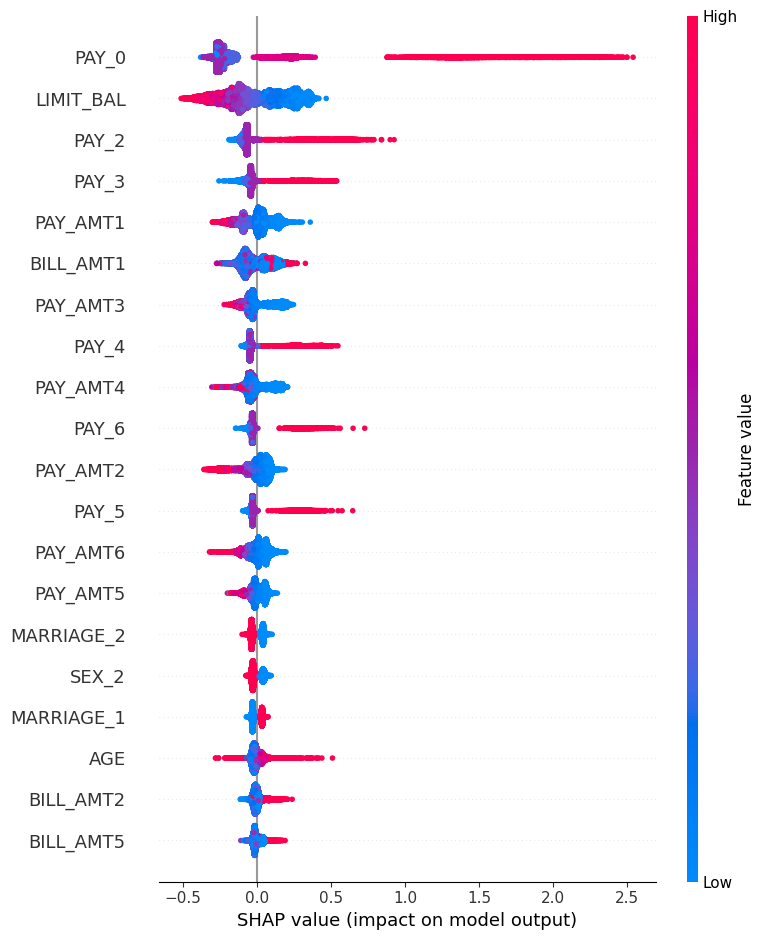

None


In [214]:
import shap

explainer = shap.TreeExplainer(cbc_optuna_train)
shap_values = explainer.shap_values(X_train)
print(shap.summary_plot(shap_values, X_train))

The `PAY_0` variable makes the strongest contribution to the prediction of default. Increasing this variable most often increases the prediction of default by the model. This is true for all variables with the prefix `PAY_`, which indicate the repayment status of the loan for a certain month. The variable `LIMIT_BAL` decreases the prediction of the default of the model when increased

## Output of final metrics on the TEST dataset

In [217]:
y_pred_test = cbc_optuna_train.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2341
           1       0.67      0.37      0.48       659

    accuracy                           0.82      3000
   macro avg       0.76      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000



The constructed model predicts to a better extent the `customers` who have `not defaulted', options for improving the accuracy of the model:
1. Collect more data on the `default` client
2. Add more `variables` to the model

## Calibration of probabilities
In order to perceive the result as a probability, it is necessary to calibrate the output of the model. This story needs to be done on test data to avoid leaks.

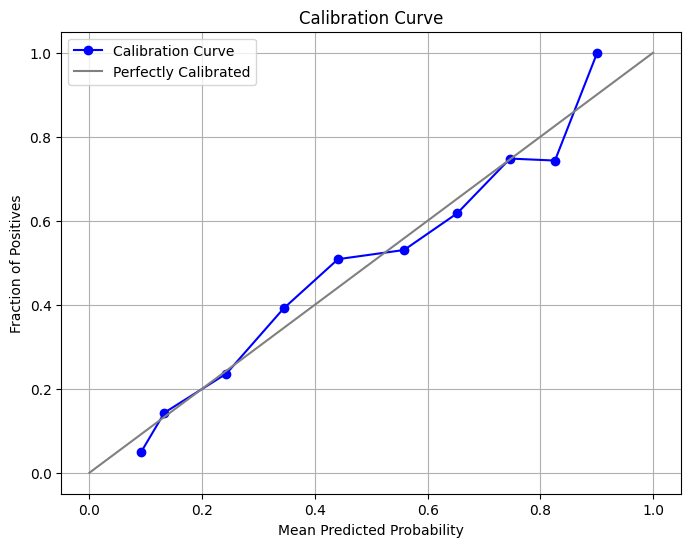

CPU times: total: 8min 12s
Wall time: 2min 7s


In [243]:
%%time
calibrated_classifier = CalibratedClassifierCV(cbc_optuna_train, method='sigmoid')
calibrated_classifier.fit(X_train, y_train)

probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, probabilities, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b', label='Calibration Curve')

plt.plot([0, 1], [0, 1], linestyle='-', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')

plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')

plt.legend()
plt.grid(True)
plt.show()

## Saving models

In [242]:
cbc_optuna_train.save_model("cbc_final")
joblib.dump(calibrated_classifier, "cbc_callib.pkl") 

['cbc_callib.pkl']